In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import joblib
import time
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
features, labels = [], []
training_files = ["dataset/individual/dataset_http_individual_attack_1.csv",
                  "dataset/individual/dataset_http_individual_normal_1.csv"]
training_files_old = ["dataset/individual/old/dataset_http_attack.csv",
                  "dataset/individual/old/dataset_http_normal_1.csv",
                  "dataset/individual/old/dataset_http_normal_2.csv"]

In [3]:
def scrape_data():
    global training_files
    global features
    global labels
    
    for fname in training_files:
        meal = open(fname, "rt")
        for line in meal:
            data_list = line.rsplit(",")
            if(len(data_list) != 11):
                print("error data")
            else:
                data_list[(len(data_list)-1)]=int(data_list[(len(data_list)-1)].replace('\n', ''))
                features.append(data_list[:(len(data_list)-1)])
                labels.append(data_list[(len(data_list)-1)])
        meal.close()
    
    for fname in training_files_old:
        meal = open(fname, "rt")
        for line in meal:
            data_list = line.rsplit(",")
            if(len(data_list) != 12):
                print("error data")
            else:
                data_list.pop(6)
                data_list[(len(data_list)-1)]=int(data_list[(len(data_list)-1)].replace('\n', ''))
                features.append(data_list[:(len(data_list)-1)])
                labels.append(data_list[(len(data_list)-1)])
        meal.close()
    
    scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
    scalar.fit(features)
    features = scalar.transform(features)
    
    features = np.array(features).astype(np.float64)
    features = features.tolist()
    
    print(f"Size of feature dataset : {len(features)}")
    print(f"Size of feature dataset : {len(labels)}")
    print("Features first and last entries:\n\t", end = "")
    print(features[:1] + features[(len(features)-1):])
    print("Labels first and last entries:\n\t", end = "")
    print(labels[:1] + labels[(len(features)-1):])
    
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.20, stratify=labels, random_state = 0)
    
    return np.asarray(features_train), np.asarray(labels_train), np.asarray(features_test), np.asarray(labels_test)

In [4]:
def generate_model(shape):
    model = Sequential()

    model.add(Dense(256, input_dim=shape, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())

    return model

In [5]:
data_train, label_train, data_eval, label_eval = scrape_data()

Size of feature dataset : 915
Size of feature dataset : 915
Features first and last entries:
	[[-0.18460964410216316, 0.1971450747783411, -0.21651632609588822, -0.4663431839356248, 0.0904182702624811, -0.4758794005665062, -0.07402741522877264, -0.5263012427769284, 0.0, 0.1628518204275064], [-1.2725137800004847, -0.6564859025495275, -0.2446198711243774, -0.4663431839356248, -0.5675415372600402, -0.5125271933341987, -0.07402741522877264, -0.5263012427769284, 0.0, -0.5793406715208417]]
Labels first and last entries:
	[1, 0]


In [6]:
model = generate_model(len(data_train[0]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2816      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2816      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
checkpoint = ModelCheckpoint("dnnModel.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='auto')

In [10]:
history = model.fit(data_train, label_train, validation_split=0.2, epochs=100, verbose = 1, callbacks=[checkpoint,early])

Epoch 1/100
14/19 [=====================>........] - ETA: 0s - loss: 0.6323 - accuracy: 0.7835 
Epoch 00001: val_loss improved from inf to 0.39188, saving model to dnnModel.h5
19/19 [==============================] - 1s 11ms/step - loss: 0.6023 - accuracy: 0.8051 - val_loss: 0.3919 - val_accuracy: 0.9184
Epoch 2/100
 1/19 [>.............................] - ETA: 0s - loss: 0.4310 - accuracy: 0.9375
Epoch 00002: val_loss improved from 0.39188 to 0.13604, saving model to dnnModel.h5
19/19 [==============================] - 0s 5ms/step - loss: 0.2624 - accuracy: 0.9470 - val_loss: 0.1360 - val_accuracy: 0.9252
Epoch 3/100
 1/19 [>.............................] - ETA: 0s - loss: 0.2446 - accuracy: 0.9062
Epoch 00003: val_loss improved from 0.13604 to 0.08465, saving model to dnnModel.h5
19/19 [==============================] - 0s 6ms/step - loss: 0.1041 - accuracy: 0.9675 - val_loss: 0.0847 - val_accuracy: 0.9728
Epoch 4/100
15/19 [======================>.......] - ETA: 0s - loss: 0.0584 - 

Epoch 29/100
17/19 [=========================>....] - ETA: 0s - loss: 0.0350 - accuracy: 0.9945
Epoch 00029: val_loss did not improve from 0.00292
19/19 [==============================] - 0s 5ms/step - loss: 0.0329 - accuracy: 0.9949 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 30/100
14/19 [=====================>........] - ETA: 0s - loss: 0.0342 - accuracy: 0.9955
Epoch 00030: val_loss did not improve from 0.00292
19/19 [==============================] - 0s 6ms/step - loss: 0.0285 - accuracy: 0.9966 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 31/100
15/19 [======================>.......] - ETA: 0s - loss: 0.0331 - accuracy: 0.9958
Epoch 00031: val_loss improved from 0.00292 to 0.00289, saving model to dnnModel.h5
19/19 [==============================] - 0s 7ms/step - loss: 0.0281 - accuracy: 0.9966 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 32/100
16/19 [========================>.....] - ETA: 0s - loss: 0.0308 - accuracy: 0.9961
Epoch 00032: val_loss improved from 0.00289

Epoch 58/100
17/19 [=========================>....] - ETA: 0s - loss: 0.0217 - accuracy: 0.9963
Epoch 00058: val_loss did not improve from 0.00175
19/19 [==============================] - 0s 5ms/step - loss: 0.0206 - accuracy: 0.9966 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 59/100
17/19 [=========================>....] - ETA: 0s - loss: 0.0236 - accuracy: 0.9963
Epoch 00059: val_loss did not improve from 0.00175
19/19 [==============================] - 0s 5ms/step - loss: 0.0224 - accuracy: 0.9966 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 60/100
14/19 [=====================>........] - ETA: 0s - loss: 0.0233 - accuracy: 0.9978
Epoch 00060: val_loss did not improve from 0.00175
19/19 [==============================] - 0s 5ms/step - loss: 0.0300 - accuracy: 0.9966 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 61/100
16/19 [========================>.....] - ETA: 0s - loss: 0.0248 - accuracy: 0.9961
Epoch 00061: val_loss did not improve from 0.00175
19/19 [==================

Epoch 88/100
14/19 [=====================>........] - ETA: 0s - loss: 0.0413 - accuracy: 0.9911
Epoch 00088: val_loss did not improve from 0.00100
19/19 [==============================] - 0s 5ms/step - loss: 0.0346 - accuracy: 0.9932 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 89/100
13/19 [===================>..........] - ETA: 0s - loss: 0.0128 - accuracy: 0.9976
Epoch 00089: val_loss did not improve from 0.00100
19/19 [==============================] - 0s 6ms/step - loss: 0.0240 - accuracy: 0.9966 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 90/100
16/19 [========================>.....] - ETA: 0s - loss: 0.0309 - accuracy: 0.9961
Epoch 00090: val_loss did not improve from 0.00100
19/19 [==============================] - 0s 5ms/step - loss: 0.0279 - accuracy: 0.9966 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 91/100
16/19 [========================>.....] - ETA: 0s - loss: 0.0358 - accuracy: 0.9961
Epoch 00091: val_loss did not improve from 0.00100
19/19 [==================

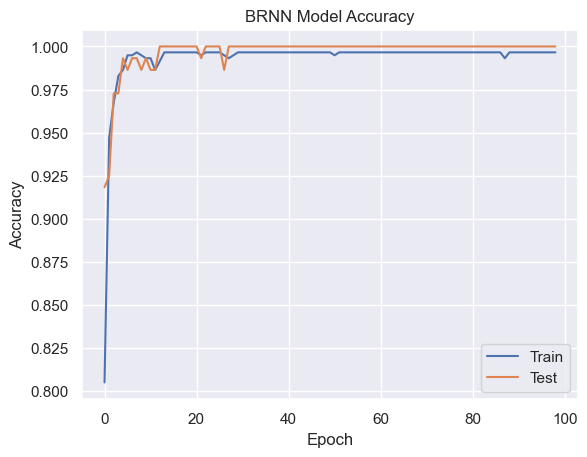

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
# plt.savefig('BRNN 200 Model Accuracy.png')
plt.show()

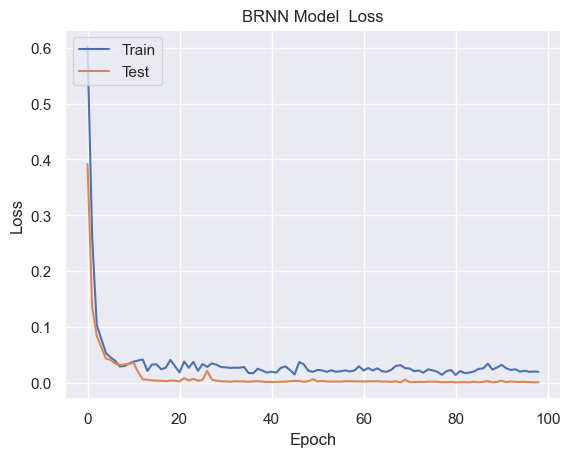

In [12]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('BRNN 200 Model Loss.png')
plt.show()

In [13]:
predict = model.predict(data_eval, verbose=1)

6/6 [==============================] - 0s 2ms/step


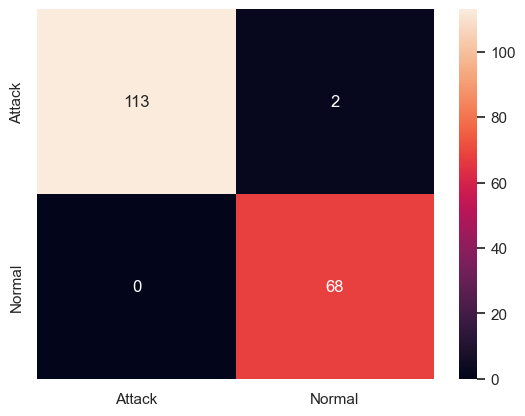

In [14]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = label_eval.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

In [15]:
scores = model.evaluate(data_eval, label_eval)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

6/6 [==============================] - 0s 3ms/step - loss: 0.0505 - accuracy: 0.9891
accuracy: 98.91%


In [16]:
print(classification_report(Y_testn,predictn))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       113
           1       1.00      0.97      0.99        70

    accuracy                           0.99       183
   macro avg       0.99      0.99      0.99       183
weighted avg       0.99      0.99      0.99       183



In [17]:
lr_auc = roc_auc_score(Y_testn, predictn)
print('SVM: ROC AUC=%.3f' % (lr_auc))

SVM: ROC AUC=0.986


In [18]:
time_start = time.perf_counter()
predict = model.predict(data_eval[:1], verbose=1)
print(f"Time elapse for prediction : {time.perf_counter() - time_start}")
print(predict)

1/1 [==============================] - 0s 13ms/step
Time elapse for prediction : 0.033990499999998036
[[1.]]
